# Duka Customer Segementation

Context: As One Acre Fund is expanding it's Duka network - OAF owned and operated agrodealers - throughout Kenya, it's imperative to drive marketing and client facing decisions on real customer data. Dukas represent a huge shift from previous business units (i.e. core program, etc.) in many ways, but most importantly in the flexible and fast-passed nature of this new retail buiness. 

Objective: The objective of this project is to use k-means clustering to; 1) segment Duka customers objectively, 2) and then use these segments to better strategize marketing and customer aquisition plays for the 2021 calendar year (for both Long Rains 2021 and Short Rains 2021 seasons). 

For this, we'll use k-means clustering for two similar customer segementation approachs
- recency, frequcny, and monetary value of customers
- total order value, total # orders, and average order value for customers

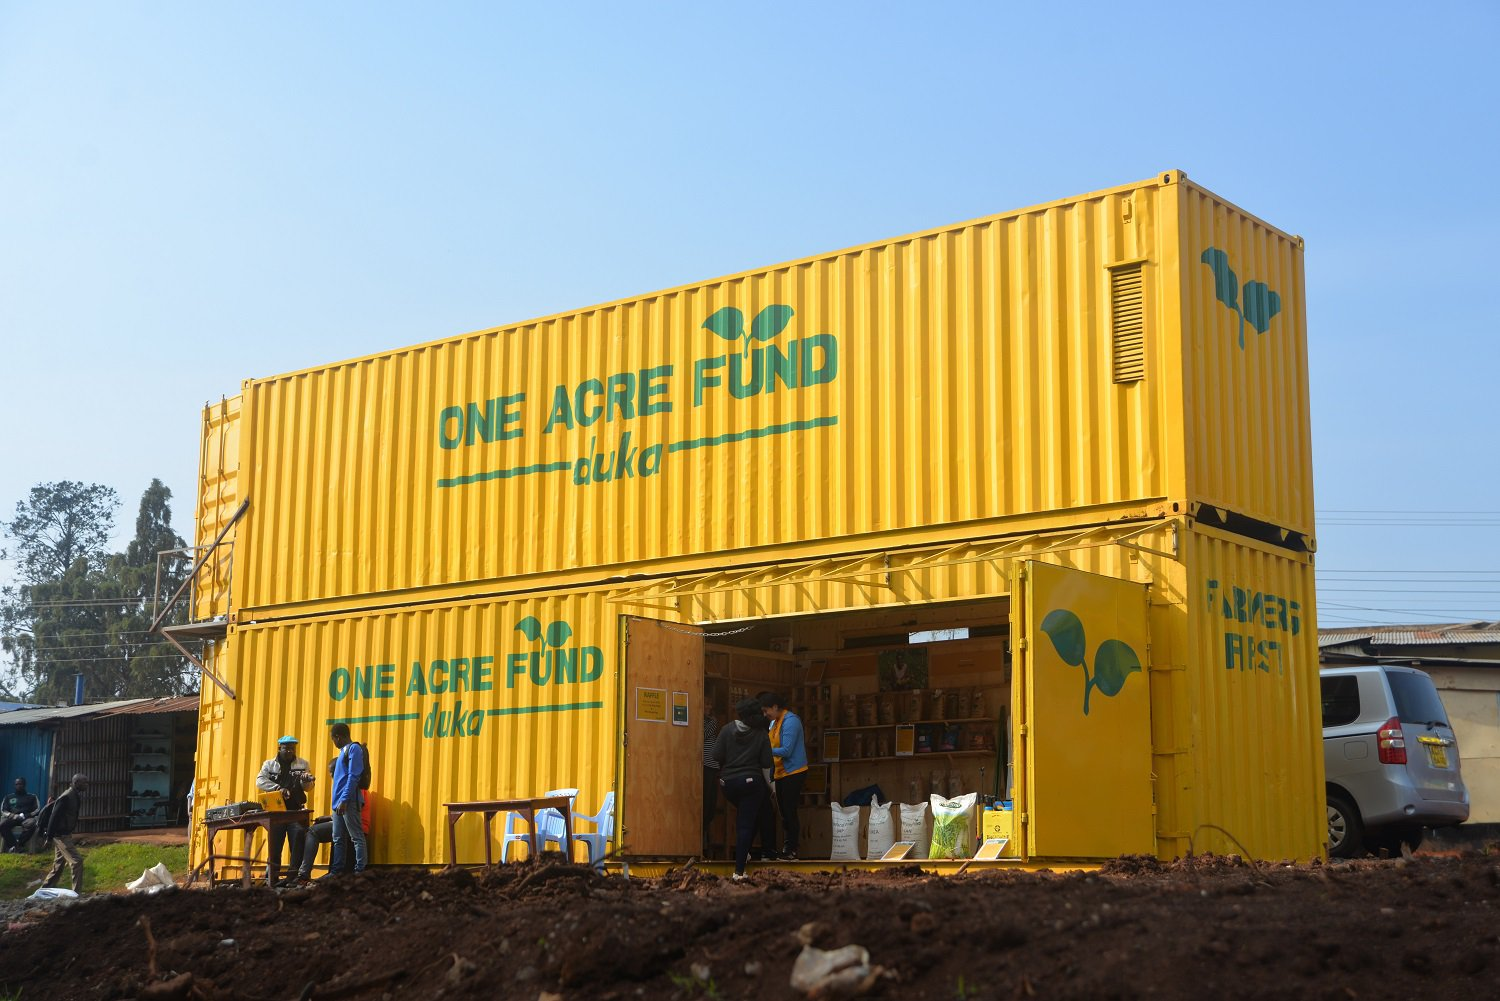
(One Acre Fund Duka in Kapsabet, Kenya)

### Import Libraries and Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import datetime as dt
import numpy as np

In [2]:
duka_data = pd.read_csv("/Volumes/GoogleDrive/My Drive/ml_projects/duka_data.csv")


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
duka_data.head()

,SaleID,DateID,InputID,WarehouseID,ClientID,EmployeeID,PointOfSaleID,DocumentNumber,ErplyInvoiceID,ErplyInvoiceRowID,CampaignNames,PaymentAuthCode,IsPromotion,Status,Price,Discount,FinalPriceWithVAT,RowTotal,Quantity,IsCredit,Inputs,Dates,UnitCost,VAT applicable,VAT rate,Final VAT rate,VAT amount
0,51100843,20200817,1309,7,22977,280,6,6.4004e+07,44828.0,67579.0,NaN,NaN,False,PAID,510.0,0.0,510.0,510.0,1.0,0,Maize; SC Duma 43; 2 KG Bag [Stock],8/17/20 0:00,450.0,0.0,0.14,0.0,0.0
1,51101102,20200817,1309,6,36663,199,5,5.40045e+07,44967.0,67926.0,NaN,NaN,False,PAID,510.0,0.0,510.0,510.0,1.0,0,Maize; SC Duma 43; 2 KG Bag [Stock],8/17/20 0:00,450.0,0.0,0.14,0.0,0.0
2,51101103,20200817,1309,6,12233,199,5,5.40045e+07,44974.0,67842.0,NaN,NaN,False,PAID,510.0,0.0,510.0,510.0,1.0,0,Maize; SC Duma 43; 2 KG Bag [Stock],8/17/20 0:00,450.0,0.0,0.14,0.0,0.0
3,51104596,20200818,1309,5,36976,194,4,4.4006e+07,45468.0,68961.0,NaN,NaN,False,PAID,510.0,0.0,510.0,510.0,1.0,0,Maize; SC Duma 43; 2 KG Bag [Stock],8/18/20 0:00,450.0,0.0,0.14,0.0,0.0
4,51104681,20200818,1309,6,12234,199,5,5.40046e+07,45428.0,68590.0,NaN,NaN,False,PAID,510.0,0.0,510.0,510.0,1.0,0,Maize; SC Duma 43; 2 KG Bag [Stock],8/18/20 0:00,450.0,0.0,0.14,0.0,0.0


### Data Preprocessing

In [4]:
duka_data_new = duka_data[['ClientID', 'Dates', 'ErplyInvoiceID', 'Quantity', 'Price', 'RowTotal']]

In [5]:
duka_data_new = duka_data_new.rename(columns = {'RowTotal':'TotalPrice'})

In [6]:
duka_data_new.head()

,ClientID,Dates,ErplyInvoiceID,Quantity,Price,TotalPrice
0,22977,8/17/20 0:00,44828.0,1.0,510.0,510.0
1,36663,8/17/20 0:00,44967.0,1.0,510.0,510.0
2,12233,8/17/20 0:00,44974.0,1.0,510.0,510.0
3,36976,8/18/20 0:00,45468.0,1.0,510.0,510.0
4,12234,8/18/20 0:00,45428.0,1.0,510.0,510.0


In [7]:
duka_data_new['Dates'].min(), duka_data_new['Dates'].max()

('1/10/20 0:00', '9/9/20 0:00')

In [8]:
PRESENT = dt.datetime(2020,12,14)
duka_data_new['Dates'] = pd.to_datetime(duka_data_new['Dates'])

### Recency, frequency, and monetary value

#### Dataframe prep

In [40]:
# prepping the data set for this customer segmentation approach 
rfm = duka_data_new.groupby('ClientID').agg({'Dates': lambda date: (PRESENT - date.max()).days,
                                        'ErplyInvoiceID': lambda num: len(num), 
                                            'TotalPrice': lambda price: price.sum()})

rfm.columns

Index(['Dates', 'ErplyInvoiceID', 'TotalPrice'], dtype='object')

In [10]:
# quick change of the column names
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.columns

Index(['recency', 'frequency', 'monetary'], dtype='object')

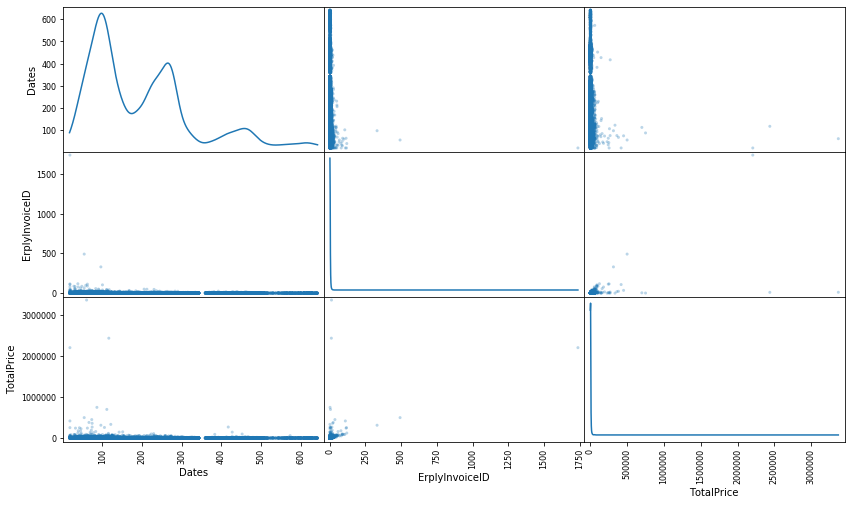

In [41]:
# Visualizing Feature Distributions
pd.plotting.scatter_matrix(rfm, alpha=0.3, figsize = (14,8), diagonal = 'kde');

Looks like we have outliers across the board that are hampering the distrubtion considerably.

#### Remove Outliers

In [12]:
from collections import Counter

def detect_outliers(rfm, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(rfm[col], 25)
        Q3 = np.percentile(rfm[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = rfm[(rfm[col] < Q1 - outlier_step) | (rfm[col] > Q3 + outlier_step)].index
                
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

lof = ['recency', 'frequency', 'monetary']

outliers_to_drop = detect_outliers(rfm, 1, lof)
len(outliers_to_drop)

1679

Using Tukey's Outlier Detection Method, there are 1679 outliets we need to drop

In [13]:
 rfm_new = rfm.drop(outliers_to_drop, axis='index')

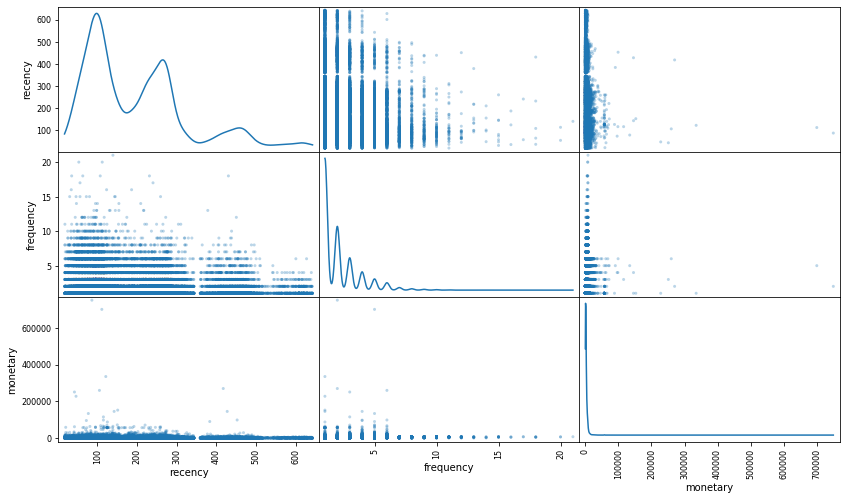

In [14]:
pd.plotting.scatter_matrix(rfm_new, alpha=0.3, figsize = (14,8), diagonal = 'kde');

Defintiely helping, but now need to scale the data since the magnitude between features is quite large!

#### Scale the Data

In [15]:
scaler = StandardScaler()
scaler.fit(rfm_new[['recency', 'frequency', 'monetary']])
rfm_new[['recency', 'frequency', 'monetary']] = scaler.transform(rfm_new[['recency', 'frequency', 'monetary']])

#### Elbow Method
Using the elbow method to determine the optimial # of clusters for this dataframe

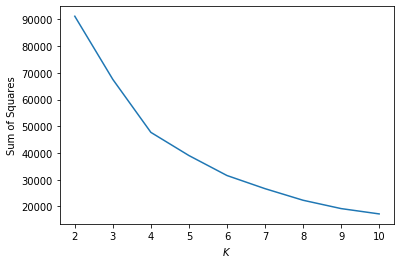

In [16]:
from sklearn import cluster 

sse = []
krange = list(range(2, 11))
X = rfm_new[['recency', 'frequency', 'monetary']].values
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2))
    
plt.plot(krange, sse)
plt.xlabel("$K$")
plt.ylabel('Sum of Squares')
plt.show()

Based on the graph above, it looks like K=4, or 4 clusters, is the optimal for this analysis.

#### Interpreting Customer Segments

In [17]:
kmeans = KMeans(n_clusters=4).fit(rfm_new[['recency', 'frequency', 'monetary']])

four_cluster_df = rfm_new[['recency', 'frequency', 'monetary']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

four_cluster_df.head(10)

,recency,frequency,monetary,Cluster
ClientID,,,,
1,-0.454145,1.772445,0.224940,2
2,-0.487655,4.247616,-0.037169,2
3,-0.956782,1.772445,0.502305,2
9,2.712468,-0.702726,-0.243808,0
11,0.366828,9.816750,0.401760,2
12,2.301981,2.391238,0.958571,2
14,2.394131,3.010030,0.190852,2
15,2.695713,-0.702726,-0.247913,0
16,0.467356,2.391238,0.176456,2


Now let's group together the cluster metrics and see what we can gather from the scaled data for each cluster. 

In [18]:
cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = four_cluster_df.columns[0:3]
cluster_center_df

,recency,frequency,monetary
0,1.013776,-0.368800,-0.132717
1,-0.675848,-0.328077,-0.100352
2,-0.404338,1.864380,0.557741
3,-0.457736,0.446461,54.957733



Cluster 1: newer clients, with low monetary value
- prioritize for "re-engaging"
- for example, let's send them a text now and try and move them from cluster 1 to cluster 3

Cluster 2: low value, low frequency customers

Cluster 3: high frequency, but lower value customers
- how to keep them engaged, and increase their overall value? 

Cluster 4: high value and high frequency customers 
- how to keep them engaged? 


#### Visualizing Clusters

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


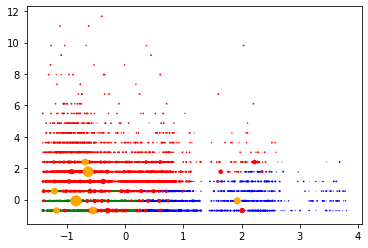

In [19]:
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['recency'],
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['frequency'],
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['monetary'], 
c='blue')

plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['recency'],
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['frequency'],
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['monetary'], 
c='green')

plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['recency'],
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['frequency'],
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['monetary'], 
c='red')

plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['recency'],
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['frequency'],
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['monetary'], 
c='orange')


#### Find the best-selling item by segment

In [57]:
cluster_1 = four_cluster_df.loc[four_cluster_df['Cluster'] == 0]

pd.DataFrame(duka_data.loc[duka_data['ClientID'].isin(cluster_1.index)].groupby(
'Inputs').count()['Quantity'].sort_values(ascending=False).head())

,Quantity
Inputs,
DAP; 18-46-0; 12.5kg [Stock],2047
DAP; 18-46-0; 25kg [Stock],1520
CAN; 26-0-0; 25kg [Stock],1461
DAP; 18-46-0; 50kg [Stock],1336
CAN; 26-0-0; 12.5kg [Stock],1242


In [61]:
print('Total Customers in Cluster 1: %0.4f' %(cluster_1['Cluster'].count()))

Total Customers in Cluster 1: 15320.0000


In [21]:
cluster_2 = four_cluster_df.loc[four_cluster_df['Cluster'] == 1]

pd.DataFrame(duka_data.loc[duka_data['ClientID'].isin(cluster_2.index)].groupby(
'Inputs').count()['Quantity'].sort_values(ascending=False).head())

,Quantity
Inputs,
Crop Storage; PICS Storage Bag [Stock],3946
DAP; 18-46-0; 12.5kg [Stock],3063
DAP; 18-46-0; 25kg [Stock],1957
CAN; 26-0-0; 25kg [Stock],1941
CAN; 26-0-0; 12.5kg [Stock],1745


In [62]:
print('Total Customers in Cluster 2: %0.4f' %(cluster_2['Cluster'].count()))

Total Customers in Cluster 2: 19018.0000


In [22]:
cluster_3 = four_cluster_df.loc[four_cluster_df['Cluster'] == 2]

pd.DataFrame(duka_data.loc[duka_data['ClientID'].isin(cluster_3.index)].groupby(
'Inputs').count()['Quantity'].sort_values(ascending=False).head())

,Quantity
Inputs,
DAP; 18-46-0; 12.5kg [Stock],3141
DAP; 18-46-0; 25kg [Stock],2300
CAN; 26-0-0; 25kg [Stock],1946
Crop Storage; PICS Storage Bag [Stock],1907
CAN; 26-0-0; 12.5kg [Stock],1660


In [64]:
print('Total Customers in Cluster 3: %0.4f' %(cluster_3['Cluster'].count()))

Total Customers in Cluster 3: 6373.0000


In [68]:
cluster_4 = four_cluster_df.loc[four_cluster_df['Cluster'] == 3]

pd.DataFrame(duka_data.loc[duka_data['ClientID'].isin(cluster_4.index)].groupby(
'Inputs').count()['Quantity'].sort_values(ascending=False).head())

,Quantity
Inputs,
CAN; 26-0-0; 50kg [Stock],6
Energy; Sun King Boom [Stock],3
Crop Storage; Harvest Drying Sheet [Stock],3
DAP; 18-46-0; 50kg [Stock],2
Crop Storage; PICS Storage Bag [Stock],2


In [69]:
print('Total Customers in Cluster 4: %0.4f' %(cluster_4['Cluster'].count()))

Total Customers in Cluster 4: 7.0000


## Average Order, # Orders, and Total Ordersize Segmentation

#### Dataframe Prep

In [24]:
duka_data_new.head()

,ClientID,Dates,ErplyInvoiceID,Quantity,Price,TotalPrice
0,22977,2020-08-17,44828.0,1.0,510.0,510.0
1,36663,2020-08-17,44967.0,1.0,510.0,510.0
2,12233,2020-08-17,44974.0,1.0,510.0,510.0
3,36976,2020-08-18,45468.0,1.0,510.0,510.0
4,12234,2020-08-18,45428.0,1.0,510.0,510.0


In [25]:
seg = duka_data_new.groupby('ClientID').agg({'ErplyInvoiceID': lambda num: len(num), 
                                            'TotalPrice': lambda price: price.sum()})

seg.columns = ['total_#_orders', 'total_order_amount']

seg['average_order_amount'] = (seg['total_order_amount'] / seg['total_#_orders'])


seg.columns



Index(['total_#_orders', 'total_order_amount', 'average_order_amount'], dtype='object')

In [26]:
seg

,total_#_orders,total_order_amount,average_order_amount
ClientID,,,
0,30.0,22718.61,757.287000
1,5.0,4500.00,900.000000
2,9.0,2610.01,290.001111
3,5.0,6500.00,1300.000000
6,11.0,9609.60,873.600000
...,...,...,...
45804,1.0,11200.00,11200.000000
45805,1.0,2880.05,2880.050000
45806,1.0,240.00,240.000000


#### Visualizing Distrubutions

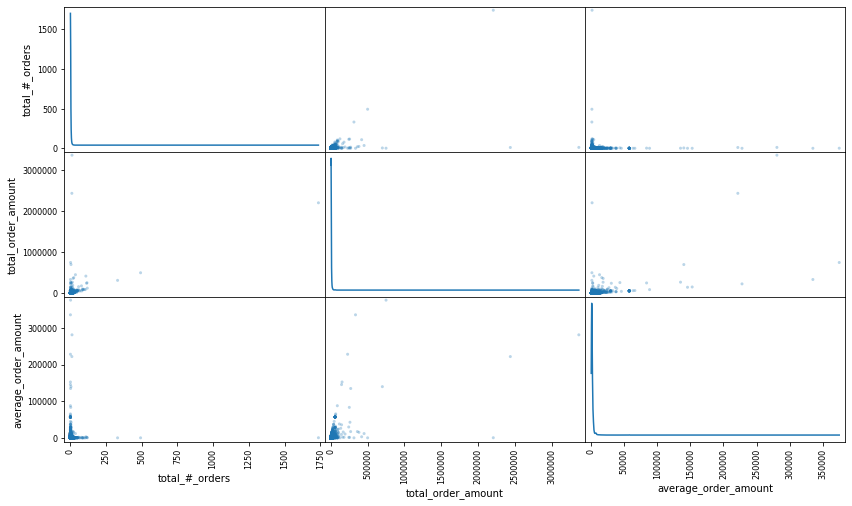

In [43]:
pd.plotting.scatter_matrix(seg, alpha=0.3, figsize = (14,8), diagonal = 'kde');

#### Removing Outliers

In [44]:
def detect_outliers_seg(seg, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(seg[col], 25)
        Q3 = np.percentile(seg[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = seg[(seg[col] < Q1 - outlier_step) | (seg[col] > Q3 + outlier_step)].index
                
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

lof_1 = ['total_#_orders', 'total_order_amount', 'average_order_amount']

outliers_to_drop_seg = detect_outliers_seg(seg, 1, lof_1)
len(outliers_to_drop_seg)

2639

In [29]:
# Using Tukey's test, drop the 2,639 that are outliers

seg_new = seg.drop(outliers_to_drop_seg, axis='index')

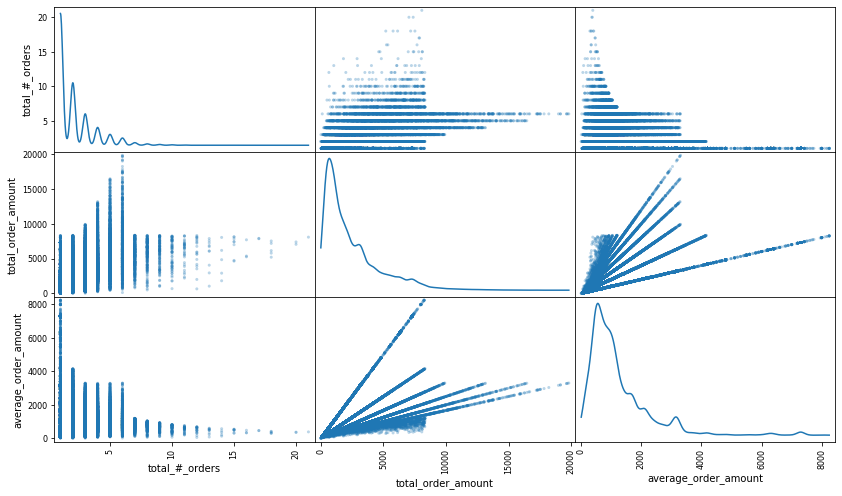

In [30]:
pd.plotting.scatter_matrix(seg_new, alpha=0.3, figsize = (14,8), diagonal = 'kde');

#### Scale the Data

In [31]:
scaler.fit(seg_new[['total_#_orders', 'total_order_amount', 'average_order_amount']])
seg_new[['total_#_orders', 'total_order_amount', 'average_order_amount']] = scaler.transform(seg_new[['total_#_orders', 'total_order_amount', 'average_order_amount']])

#### Elbow Method
To determine the optimal number of clusters for this dataset.

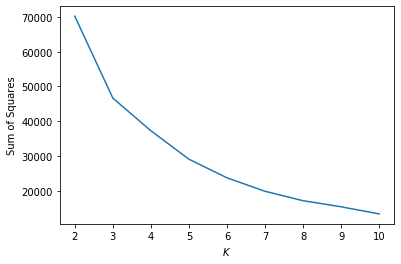

In [32]:
sse_1 = []
krange_1 = list(range(2, 11))
X_1 = seg_new[['total_#_orders', 'total_order_amount', 'average_order_amount']].values
for n in krange_1:
    model = cluster.KMeans(n_clusters=n, random_state=3)
    model.fit_predict(X_1)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse_1.append(np.sum((X_1 - centers[cluster_assignments]) ** 2))
    
plt.plot(krange_1, sse_1)
plt.xlabel("$K$")
plt.ylabel('Sum of Squares')
plt.show()

Based on the graph above, it looks like K=3, or 3 clusters, is the optimal for this analysis.

#### Interpreting Customer Segments

In [33]:
kmeans_1 = KMeans(n_clusters=3).fit(seg_new[['total_#_orders', 'total_order_amount', 'average_order_amount']])

three_cluster_df = seg_new[['total_#_orders', 'total_order_amount', 'average_order_amount']].copy(deep=True)
three_cluster_df['Cluster'] = kmeans_1.labels_

three_cluster_df.head(10)

,total_#_orders,total_order_amount,average_order_amount,Cluster
ClientID,,,,
1,1.772092,0.896138,-0.294489,2
2,4.239409,0.080671,-0.871616,2
3,1.772092,1.759070,0.083956,2
9,-0.695224,-0.562218,-0.086344,1
11,9.790872,1.446257,-0.842445,2
12,2.388922,3.178594,0.397750,2
14,3.005751,0.790083,-0.570996,2
15,-0.695224,-0.574989,-0.114349,1
16,2.388922,0.745297,-0.491532,2


Now let's group together the cluster metrics and see what we can gather from the scaled data for each cluster. 

In [34]:
cluster1_metrics_seg = kmeans_1.cluster_centers_[0]
cluster2_metrics_seg = kmeans_1.cluster_centers_[1]
cluster3_metrics_seg = kmeans_1.cluster_centers_[2]

data_seg = [cluster1_metrics_seg, cluster2_metrics_seg, cluster3_metrics_seg]
cluster_center_df_seg = pd.DataFrame(data_seg)

cluster_center_df_seg.columns = three_cluster_df.columns[0:3]
cluster_center_df_seg

,total_#_orders,total_order_amount,average_order_amount
0,-0.435451,0.899644,2.070592
1,-0.353380,-0.502628,-0.355600
2,1.683041,1.400273,0.052604


Looking at the cluster trends above, it seems the three clusters represent:

Cluster 1: fewer, larger orders

Cluster 2: few, small orders

Cluster 3: many, smaller orders

#### Visualizing the Clusters

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


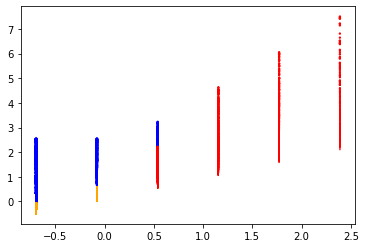

In [35]:
plt.scatter(
three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['total_#_orders'],
three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['total_order_amount'],
three_cluster_df.loc[three_cluster_df['Cluster'] == 0]['average_order_amount'], 
c='blue')

plt.scatter(
three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['total_#_orders'],
three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['total_order_amount'],
three_cluster_df.loc[three_cluster_df['Cluster'] == 1]['average_order_amount'], 
c='orange')

plt.scatter(
three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['total_#_orders'],
three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['total_order_amount'],
three_cluster_df.loc[three_cluster_df['Cluster'] == 2]['average_order_amount'], 
c='red')

plt.show()


#### Finding the best-selling item by segment

Cluster 1: fewer, larger orders

In [45]:
cluster_1_seg = three_cluster_df.loc[three_cluster_df['Cluster'] == 0]

pd.DataFrame(duka_data.loc[duka_data['ClientID'].isin(cluster_1_seg.index)].groupby(
'Inputs').count()['Quantity'].sort_values(ascending=False).head())

,Quantity
Inputs,
DAP; 18-46-0; 50kg [Stock],1630
Crop Storage; Harvest Drying Sheet [Stock],754
CAN; 26-0-0; 50kg [Stock],516
Crop Storage; PICS Storage Bag [Stock],448
DAP; 18-46-0; 25kg [Stock],338


In [70]:
print('Total Customers in Cluster 1: %0.4f' %(cluster_1_seg['Cluster'].count()))

Total Customers in Cluster 1: 4623.0000


Cluster 2: few, small orders

In [37]:
cluster_2_seg = three_cluster_df.loc[three_cluster_df['Cluster'] == 1]

pd.DataFrame(duka_data.loc[duka_data['ClientID'].isin(cluster_2_seg.index)].groupby(
'Inputs').count()['Quantity'].sort_values(ascending=False).head())

,Quantity
Inputs,
DAP; 18-46-0; 12.5kg [Stock],4812
Crop Storage; PICS Storage Bag [Stock],4459
CAN; 26-0-0; 12.5kg [Stock],2889
CAN; 26-0-0; 25kg [Stock],2853
DAP; 18-46-0; 25kg [Stock],2573


In [71]:
print('Total Customers in Cluster 2: %0.4f' %(cluster_2_seg['Cluster'].count()))

Total Customers in Cluster 2: 28044.0000


Cluster 3: many, smaller orders

In [38]:
cluster_3_seg = three_cluster_df.loc[three_cluster_df['Cluster'] == 2]

pd.DataFrame(duka_data.loc[duka_data['ClientID'].isin(cluster_3_seg.index)].groupby(
'Inputs').count()['Quantity'].sort_values(ascending=False).head())

,Quantity
Inputs,
DAP; 18-46-0; 12.5kg [Stock],3297
DAP; 18-46-0; 25kg [Stock],2789
CAN; 26-0-0; 25kg [Stock],2274
Crop Storage; PICS Storage Bag [Stock],1982
DAP; 18-46-0; 50kg [Stock],1860


In [72]:
print('Total Customers in Cluster 3: %0.4f' %(cluster_3_seg['Cluster'].count()))

Total Customers in Cluster 3: 7091.0000
